In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plot
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import odeint
import matplotlib.dates as mdate
import pandas as pd

In [2]:
def update_model(X,A,incubation,betae,betai,alpha,gamma,p,w,c):
    ID = np.arange(len(A))
    nX = X.copy()
    for i in range(len(X)):
        neighbor_ID = ID[A[i]>0]#寻找邻居
        if X[i] == 0:#suspectible 
            #统计邻居节点状态进行感染
            #计算有多少
            nume=0
            numi=0
            for ni in neighbor_ID:
                if X[ni] == 1:
                    #S碰到E，统计人数
                    nume+=1
                elif X[ni] == 2:
                    #S碰到I
                    numi+=1
            #根据现有多少个A和I来计算传播概率*管控力度
            if np.random.random()< c*(1-(1-betai)**numi*(1-betae)**nume):
                nX[i] = 1
        if X[i] == 1:#ecubate
            #以潜伏天数的倒数*一定感染概率alpha转为确诊，或被移除
            if np.random.random()< 1/incubation:
                if np.random.random()< alpha:
                    nX[i] = 2#i
                else:
                    nX[i] = 4#r
                #检测力度被检测出来
                if np.random.random()< p:
                    nX[i] = 3#t
        if X[i] == 2:#infected to tested or recover 
            if np.random.random()< w * p:
                nX[i] = 3#t
            if np.random.random() < gamma:
                nX[i] = 4      
    return nX
                    
    
def loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time):
    T = 50
    Xp = X0.copy()
    S = np.zeros(T)
    E = np.zeros(T)
    I = np.zeros(T)
    Te = np.zeros(T)
    R = np.zeros(T)
    
    S[0] = np.sum(X0==0)
    E[0] = np.sum(X0==1)
    I[0] = np.sum(X0==2)
    Te[0] = np.sum(X0==3)
    R[0] = np.sum(X0==4)
    
    for t in range(T-1):  
        nX = update_model(Xp,A,incubation,betae,betai,alpha,gamma,p,w,c)
        Xp = nX.copy()
        S[t+1] = np.sum(nX==0)
        E[t+1] = np.sum(nX==1)
        I[t+1] = np.sum(nX==2)
        Te[t+1] = np.sum(nX==3)
        R[t+1] = np.sum(nX==4)
    return S,E,I,Te,R,nX 

In [3]:
#初始条件
#初始网络
ws1 = nx.random_graphs.watts_strogatz_graph(2000, 50, 0.01)
ws2 = nx.random_graphs.watts_strogatz_graph(2000, 50, 0.0001)

In [4]:
WC = nx.to_numpy_array(ws1)
WR = nx.to_numpy_array(ws2)

In [37]:
#平均聚集系数
np.array(list(nx.clustering(ws2).values())).mean()

0.7343595858343338

np.array(list(nx.clustering(WR).values())).mean()

In [5]:
nx.average_shortest_path_length(ws1)

3.453834417208604

In [6]:
nx.average_shortest_path_length(ws2)

12.167585792896448

In [30]:
def call(A):    
    r0 = 12
    gamma = 1/14
    betae = r0*gamma
    betai = r0*gamma*6/4
    incubation = 9.5
    alpha = 0.13

    #核酸检测窗口
    w = 1/7

    #检测力度
    p = 1

    #接触能力
    c = 0.02

    #静态管控时长
    control_time = 300

    X0 = np.zeros(len(A))
    #seed spreader
    X0[60] = 2

    interval = []
    fig = plt.figure(figsize=(12,8))
    plt.tick_params(labelsize = 25)
    #************多次模拟**************#
    for ii in range(30):
        S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
        plt.plot(Te)
        time = 0
        for jj in range(len(Te)):
                if Te[jj]>50:
                    time = jj-1
                if time != 0:
                    break
        if time != 0:
            interval.append(time)
    # data.reset_index(drop=True, inplace=True)
    # plt.plot(aug_data['累计新增'][:len(Te)],marker='o',lw=1,c='b',label = 'Real Data')
    # plt.legend(fontsize = 18)
    return interval

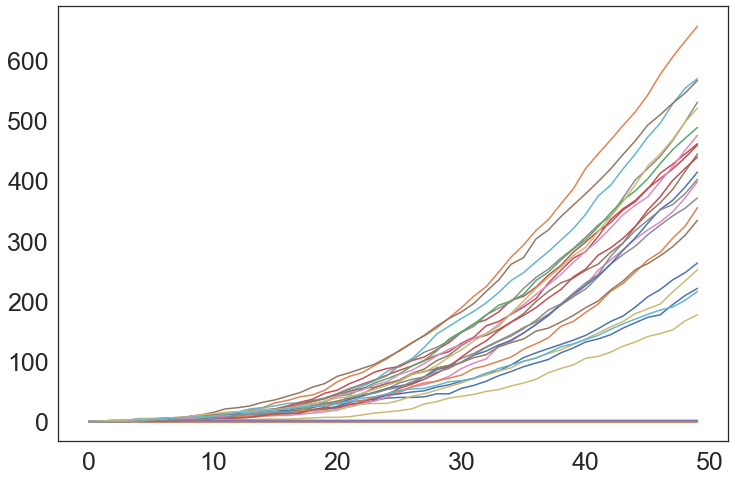

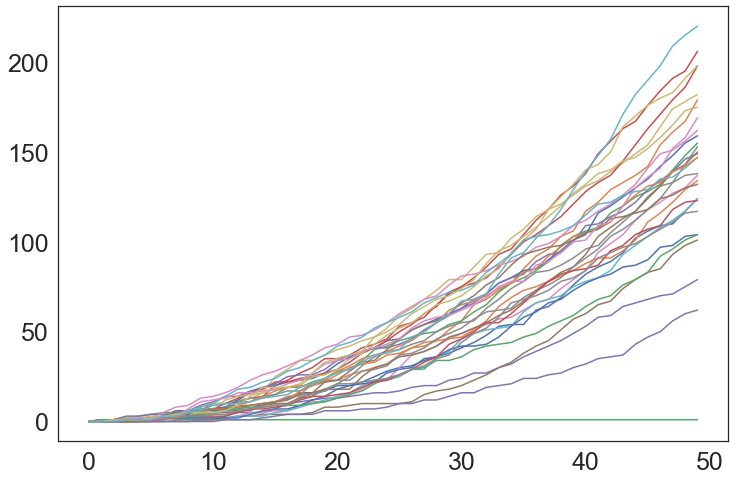

In [31]:
interC = call(WC)
interR = call(WR)

In [32]:
xc = pd.Series(interC)  

In [33]:
xr = pd.Series(interR)  

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


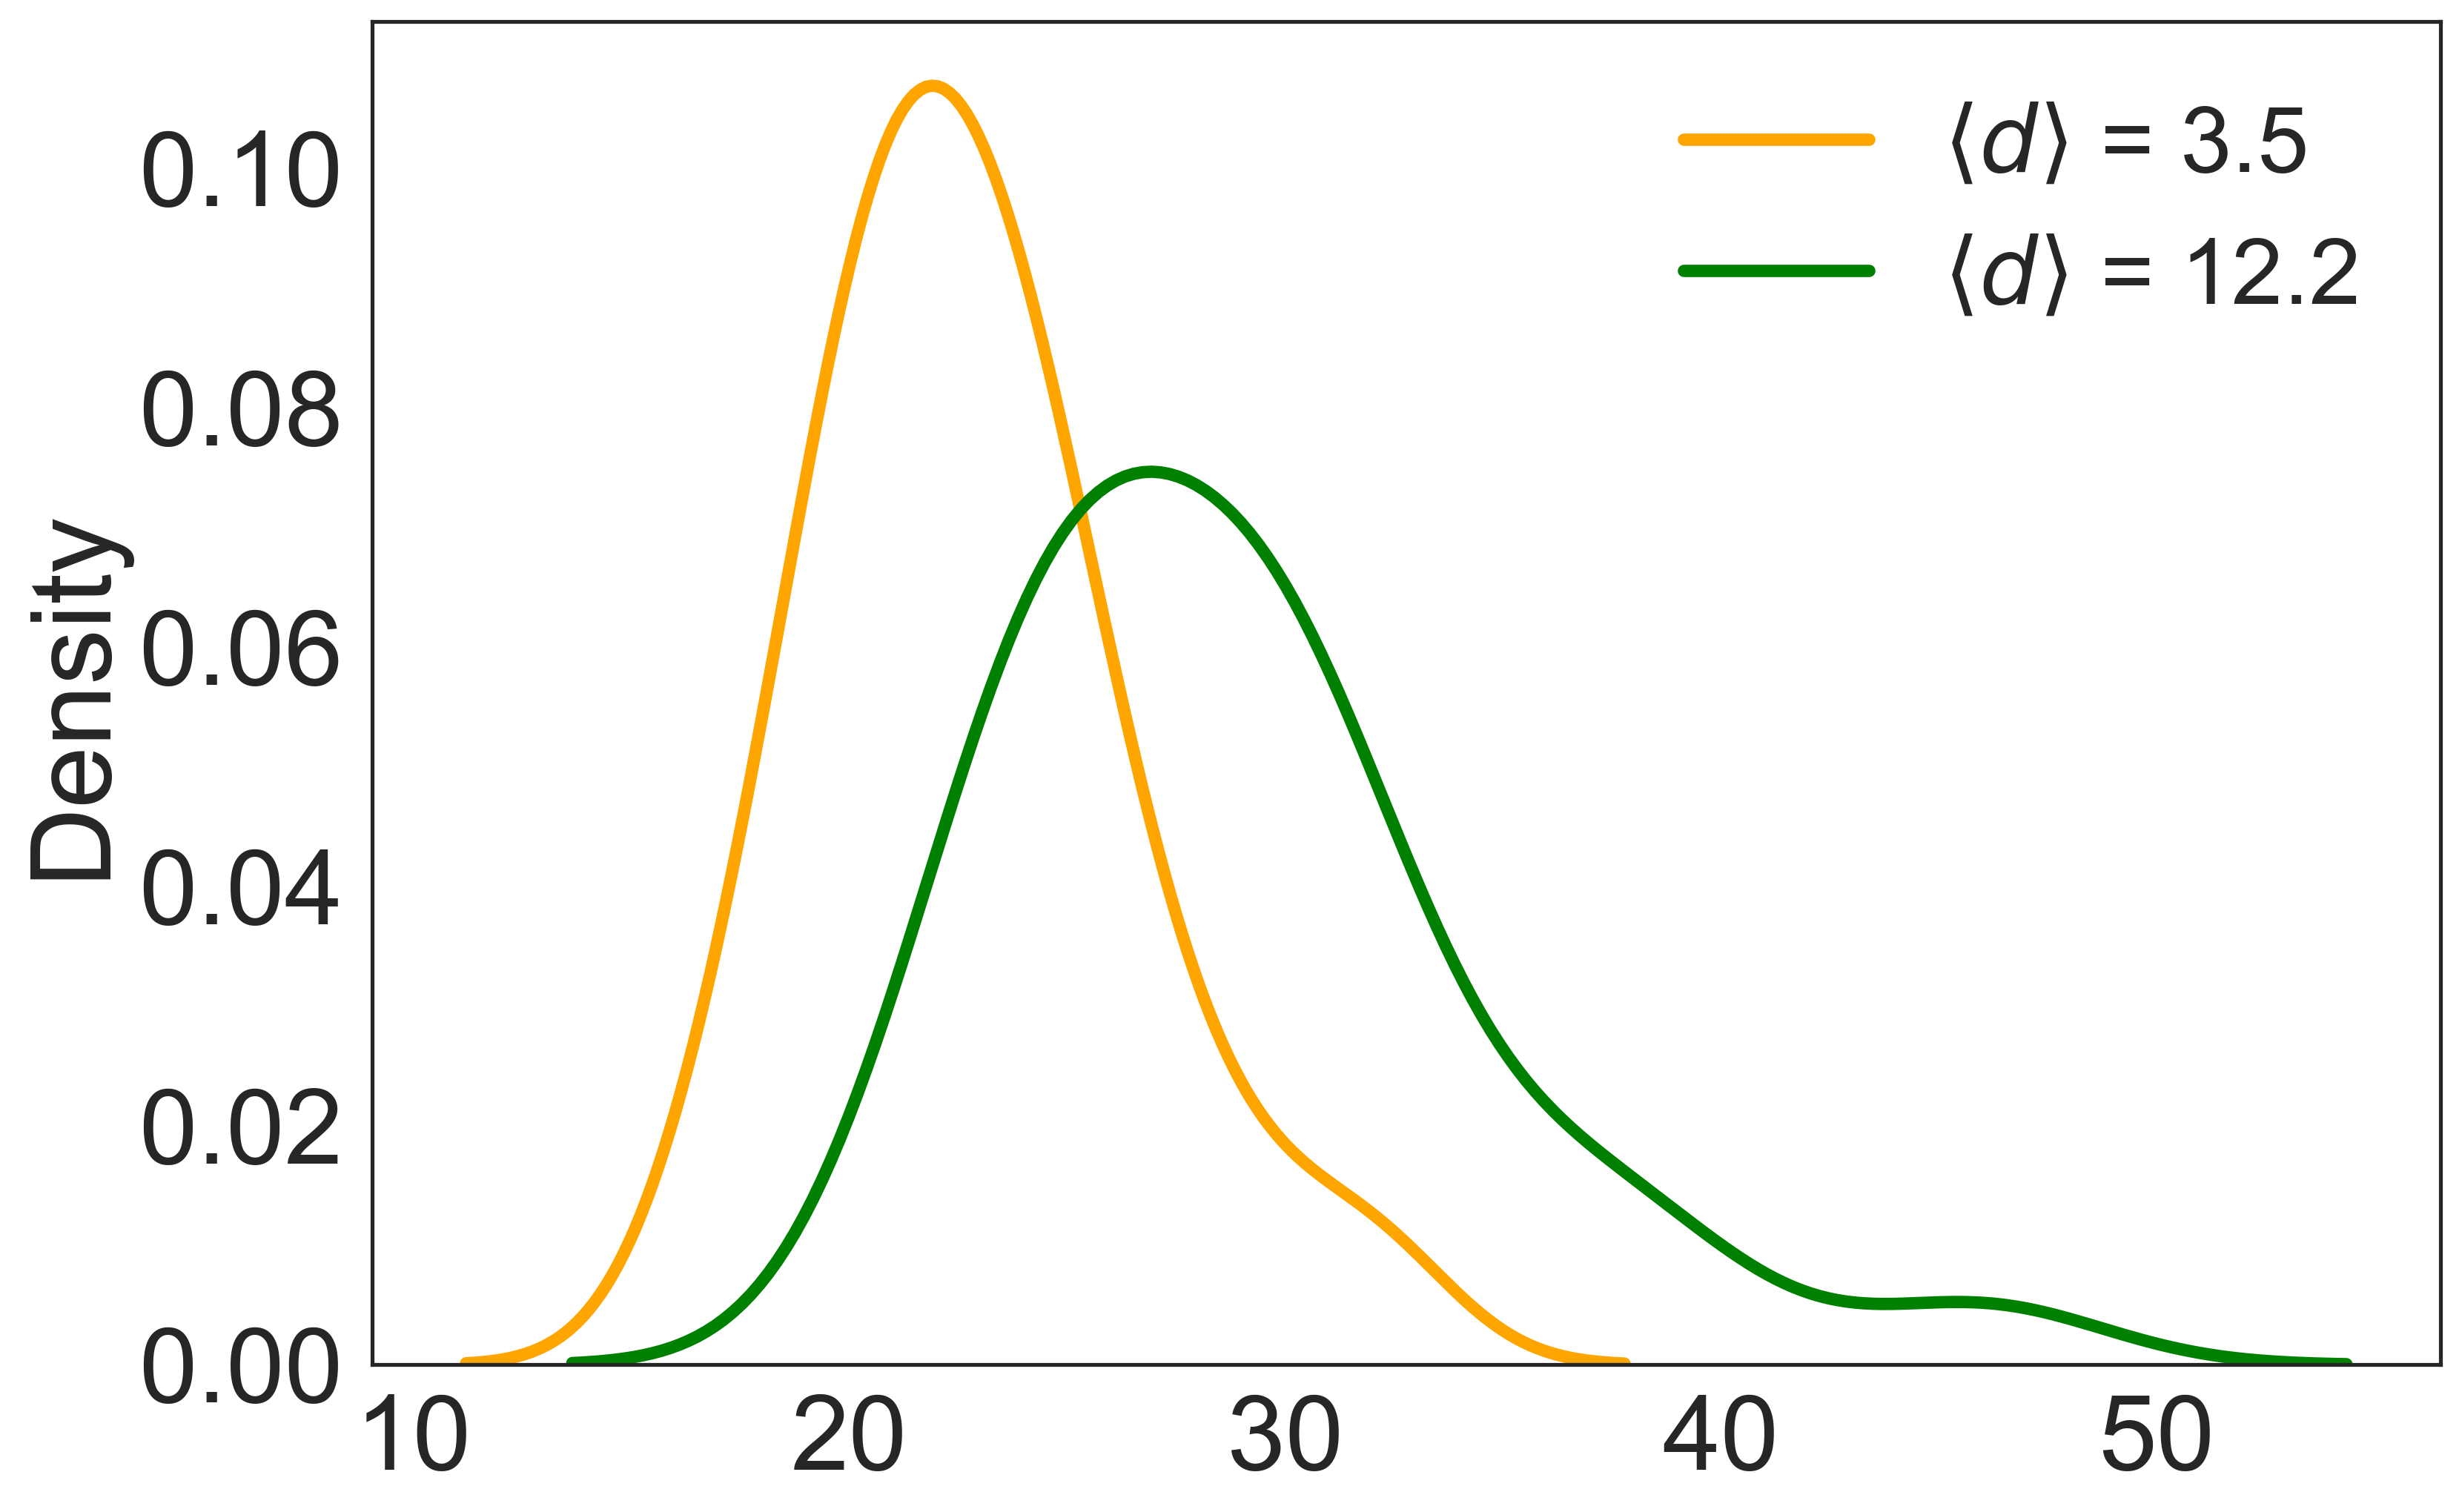

In [34]:
import seaborn as sns
sns.set(font_scale=3)
sns.set_style(style='white') 
fig = plt.figure(figsize=(12,8),dpi=300)
sns.distplot(xc, hist=False, kde=True, 
             bins=10, color = 'orange', 
             kde_kws={'linewidth': 4}, label = r'$\langle d\rangle$ = 3.5')
sns.distplot(xr, hist=False, kde=True, 
             bins=10, color = 'green', 
             kde_kws={'linewidth': 4}, label =  r'$\langle d\rangle$ = 12.2')
plt.legend(fontsize = 30,frameon = False)
plt.tick_params(labelsize = 34)

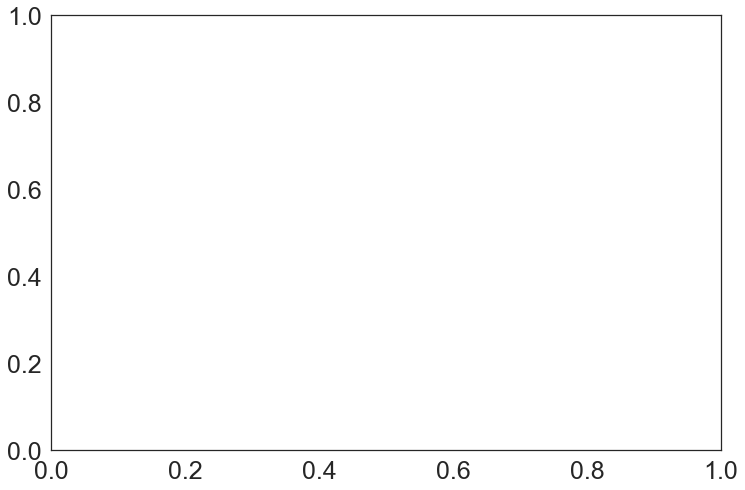

In [185]:
r0 = 12
gamma = 1/14
betae = r0*gamma
betai = r0*gamma*6/4
incubation = 9.5
alpha = 0.13

#核酸检测窗口
w = 1

#检测力度
p = 0.8

#接触能力
c = 0.1

#静态管控时长
control_time = 300

X0 = np.zeros(len(A))
#seed spreader
X0[60] = 2

interval = []
fig = plt.figure(figsize=(12,8))
plt.tick_params(labelsize = 25)
#************多次模拟**************#
for ii in range(500):
    S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
#     plt.plot(Te)
    time = 0
    for jj in range(len(Te)):
            if Te[jj]>50:
                time = jj-1
            if time != 0:
                break
    if time != 0:
        interval.append(time)
# data.reset_index(drop=True, inplace=True)
# plt.plot(aug_data['累计新增'][:len(Te)],marker='o',lw=1,c='b',label = 'Real Data')
# plt.legend(fontsize = 18)

In [180]:
t0=Te.copy()

In [186]:
t1=Te.copy()

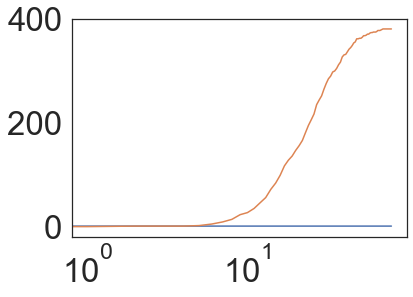

In [187]:
plt.semilogx(t0)
plt.plot(t1)

In [181]:
x0 = pd.Series(interval)  

In [188]:
x1 = pd.Series(interval)

/Users/avecsally/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/avecsally/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


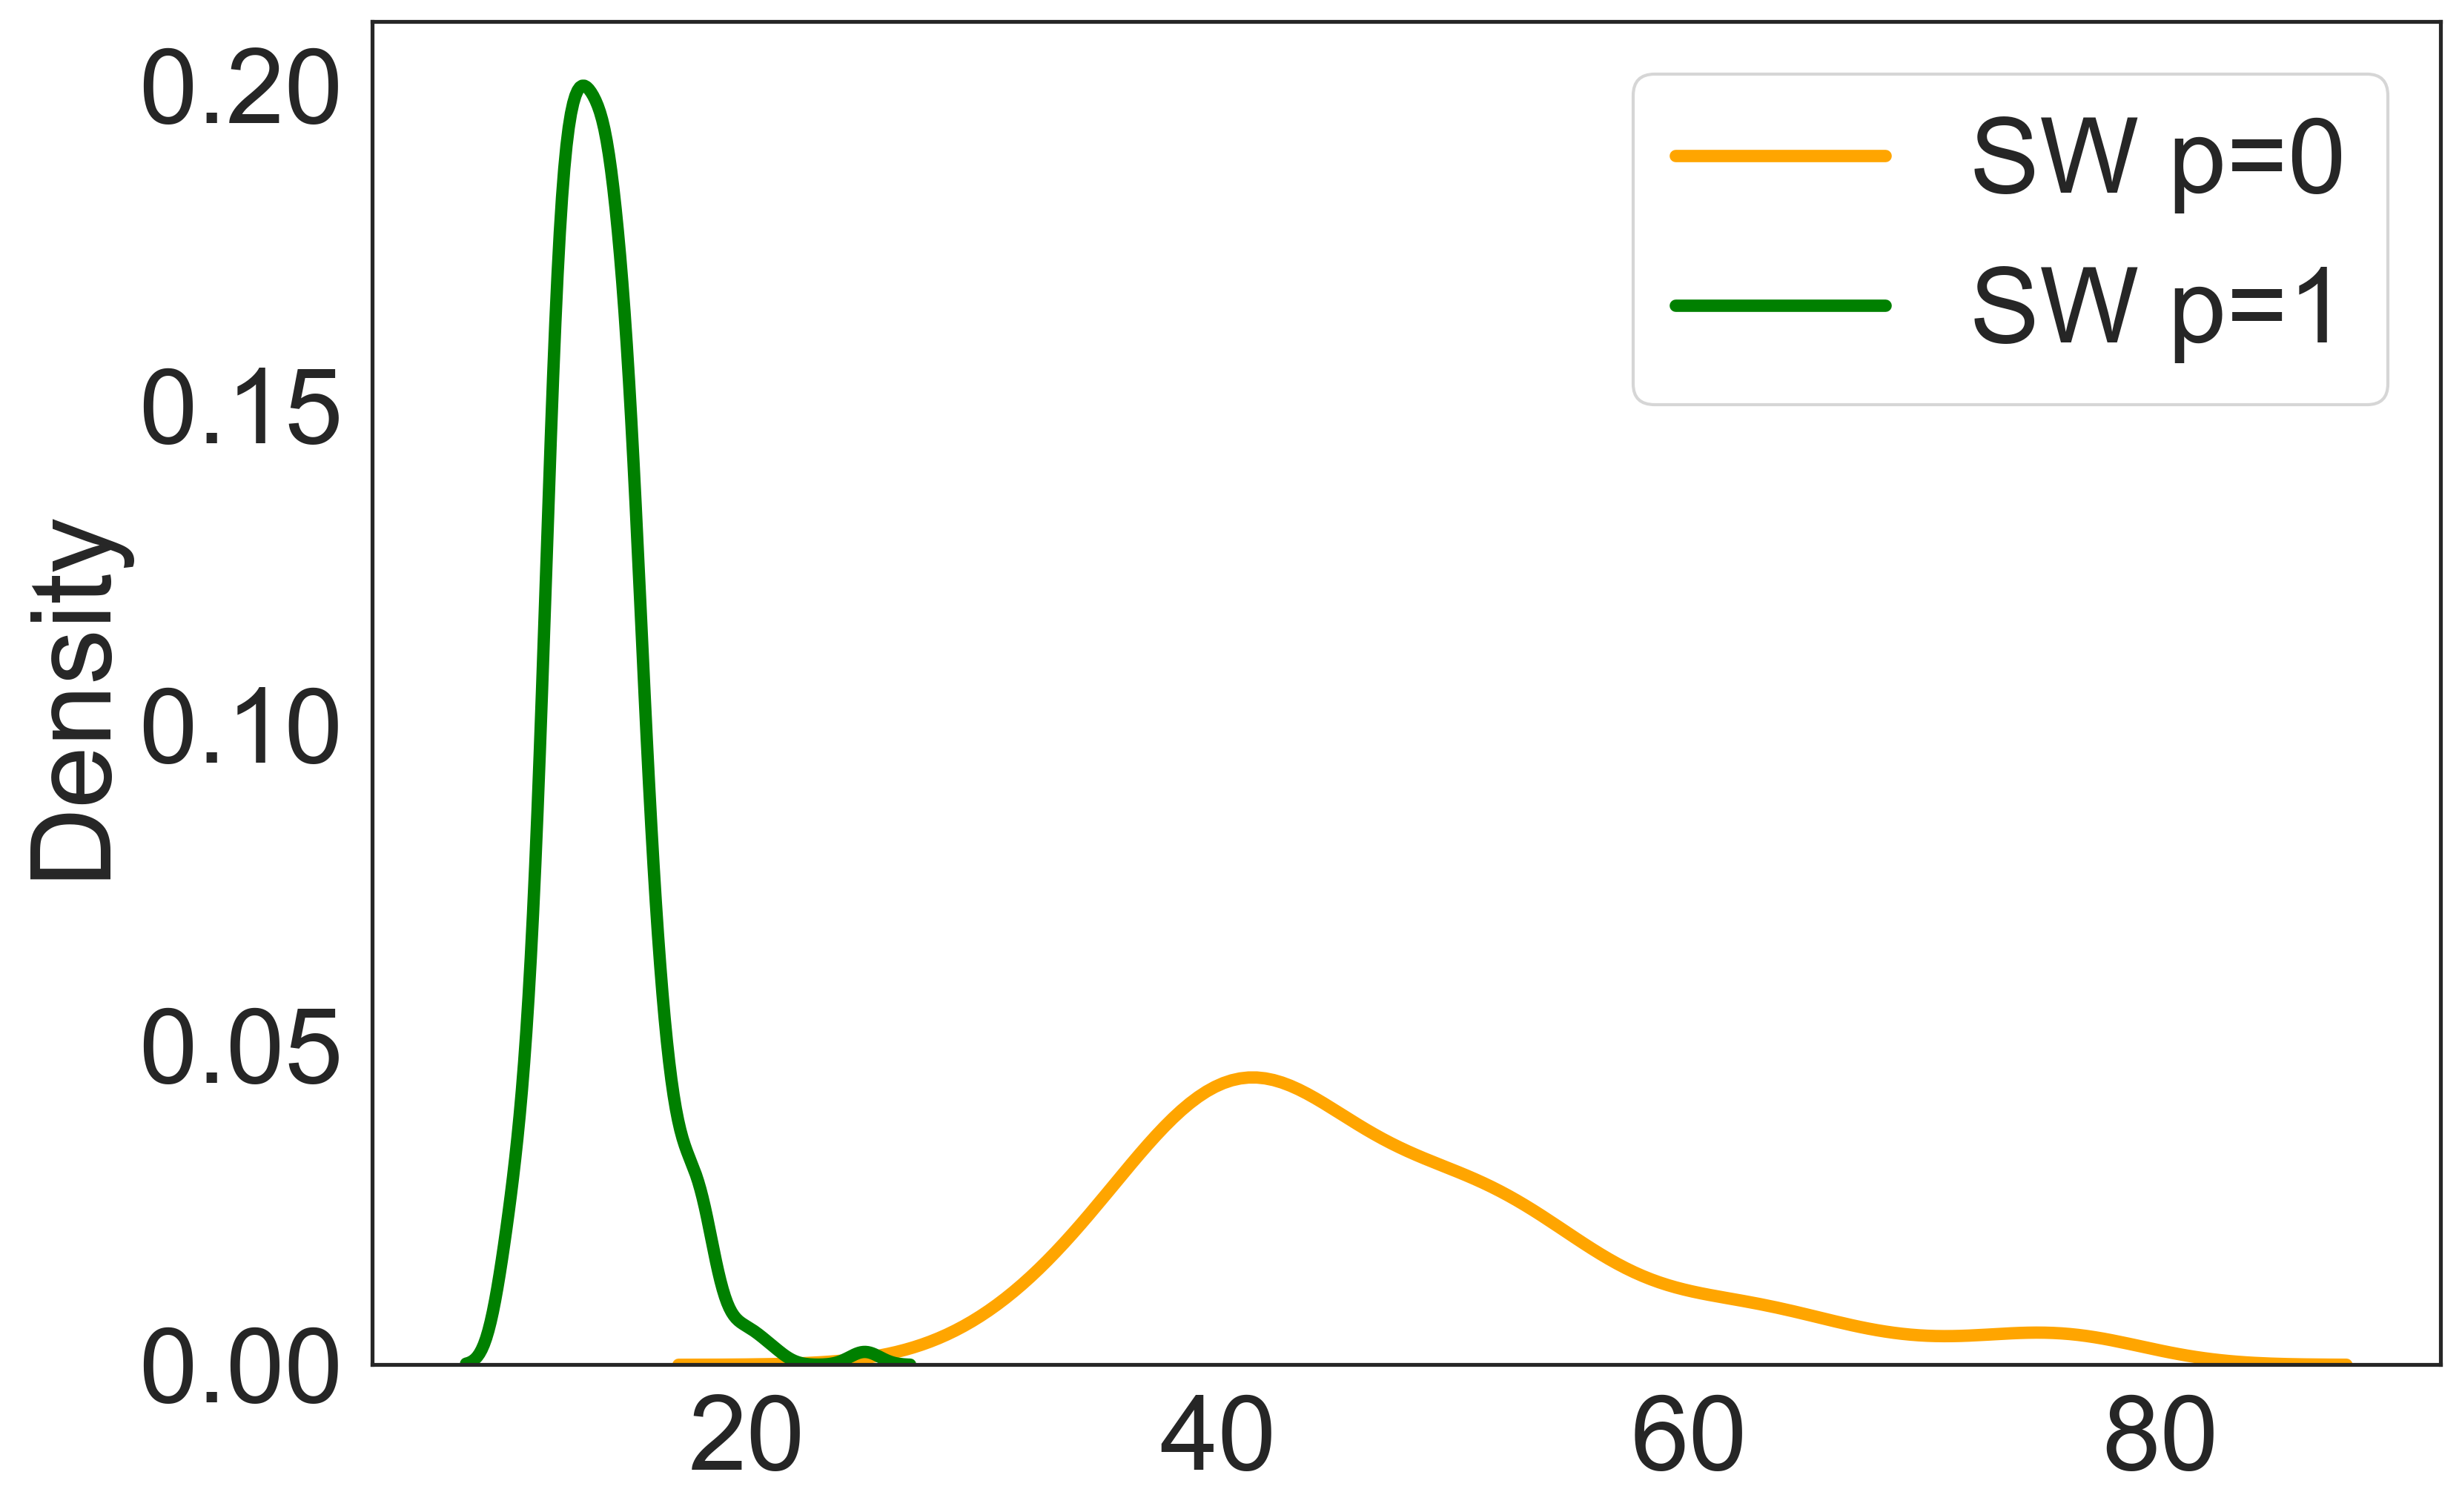

In [190]:
import seaborn as sns
sns.set(font_scale=3)
sns.set_style(style='white') 
fig = plt.figure(figsize=(12,8),dpi=300)
sns.distplot(x0, hist=False, kde=True, 
             bins=10, color = 'orange', 
             kde_kws={'linewidth': 4}, label = 'SW p=0')
sns.distplot(x1, hist=False, kde=True, 
             bins=10, color = 'green', 
             kde_kws={'linewidth': 4}, label = 'SW p=1')
plt.legend(fontsize = 34)
plt.tick_params(labelsize = 34)

In [90]:
import random
import networkx as nx
import matplotlib.pyplot as plot
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.integrate import odeint
import matplotlib.dates as mdate
import pandas as pd
from numba import njit,prange

In [80]:
ws = nx.random_graphs.watts_strogatz_graph(2000, 50, 0.0001)
A_0 = nx.to_numpy_array(ws)

In [81]:
nx.average_shortest_path_length(ws)

16.530246623311655

In [82]:
#平均聚集系数
np.array(list(nx.clustering(ws).values())).mean()

0.7345674629851942

- 聚集系数都约为0.7，最短路径p=0.01, 3.35
- p=0.0001, 10


In [94]:
A=A_0+0
ST=[]
for c in np.linspace(0,0.01,10):
    r0 = 12
    gamma = 1/14
    betae = r0*gamma
    betai = r0*gamma
    incubation = 9.5
    alpha = 0.13
    #核酸检测窗口
    w = 1/7
    #检测力度
    p = 1
    #接触能力
#     c = 0.03
    #静态管控时长
    control_time = 300
    X0 = np.zeros(len(A))
    #seed spreader
    X0[60] = 2

    
    pnum = 30 ### 随机模拟次数
    res = parallel_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time,pnum)
    ST.append(res)

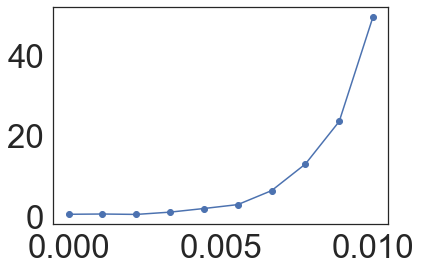

In [95]:
plt.plot(np.linspace(0,0.01,10),ST,'-o')

In [96]:
A=A_0+0
M_s0=[]

for w in np.linspace(0,1,20):
    ST_s0=[]
    for c in np.linspace(0,0.1,20):
        r0 = 12
        gamma = 1/14
        betae = r0*gamma
        betai = r0*gamma
        incubation = 9.5
        alpha = 0.13
        p = 1
        control_time = 300
        X0 = np.zeros(len(A))
        #seed spreader
        X0[60] = 2


        pnum = 50 ### 随机模拟次数
        res = parallel_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time,pnum)
        ST_s0.append(res)
    M_s0.append(ST_s0)
    print(ST_s0)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.46, 2.56, 29.6, 80.14, 127.36, 172.22, 178.46, 192.14, 192.34, 195.18, 197.4, 200.08, 205.88, 198.74, 203.24, 208.38, 204.94, 204.08, 206.12, 208.96]
[0.56, 3.48, 41.66, 111.04, 197.94, 256.32, 294.62, 303.4, 312.9, 330.84, 329.38, 337.9, 339.28, 337.12, 339.82, 344.44, 345.4, 340.04, 343.1, 341.66]
[0.6, 3.36, 44.88, 154.26, 267.4, 358.88, 379.86, 420.86, 400.58, 404.88, 432.58, 429.28, 445.28, 448.96, 459.46, 453.4, 459.1, 463.88, 459.56, 463.1]
[0.62, 5.34, 62.94, 184.6, 312.9, 425.42, 476.08, 474.02, 484.78, 537.5, 544.02, 558.06, 556.22, 564.14, 565.3, 565.9, 571.54, 571.78, 571.08, 559.5]
[0.84, 2.66, 70.52, 202.5, 352.18, 505.0, 579.88, 598.5, 595.82, 601.04, 656.56, 636.4, 624.6, 663.54, 671.64, 657.58, 656.5, 657.7, 668.58, 670.04]
[0.86, 2.08, 71.18, 234.84, 413.36, 586.5, 680.72, 685.84, 720.76, 677.62, 741.78, 765.14, 730.5, 753.3, 769.36, 757.8, 753.76, 754.12, 769.16, 7

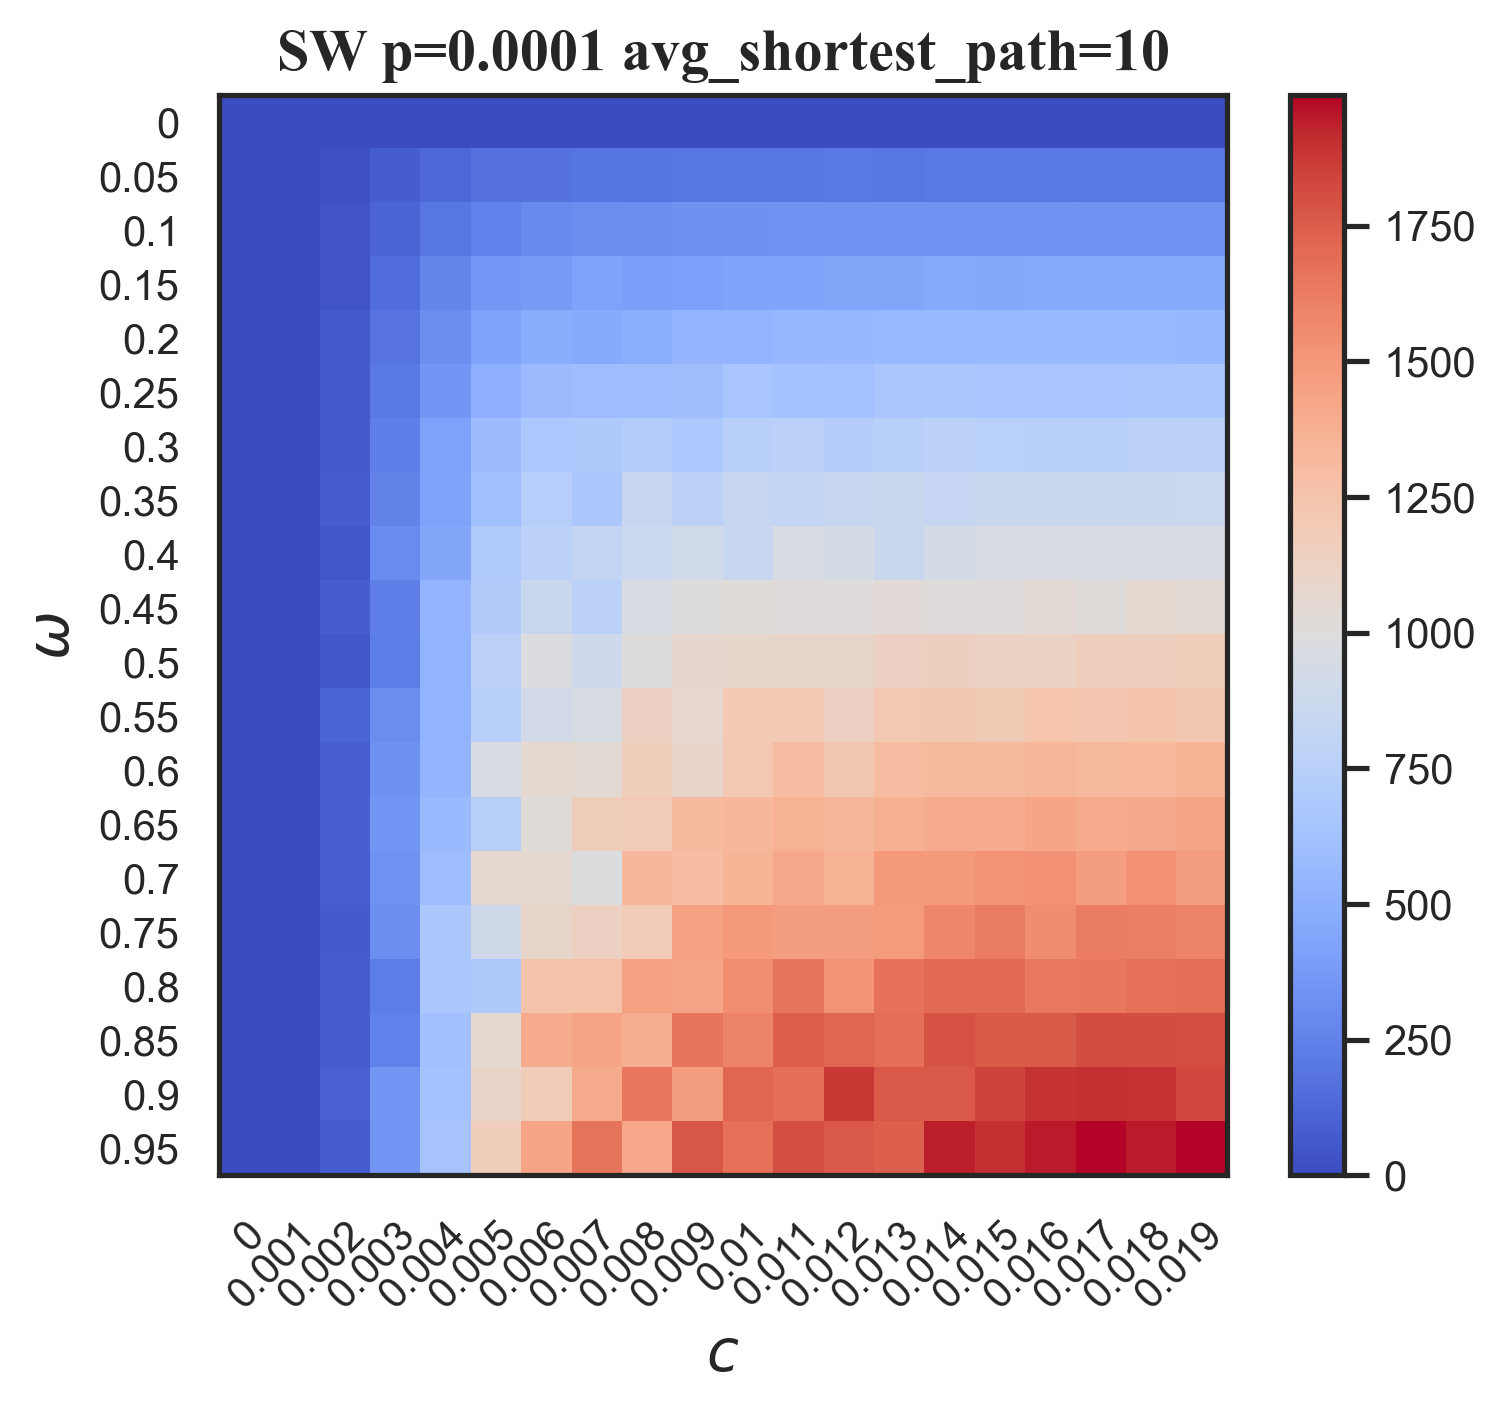

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
plt.subplots_adjust(top=0.94, bottom=0.22, left=0.15, right=0.99, hspace=0,
                    wspace=0)

tag_y = ["0", "0.05",  "0.1",  "0.15", "0.2", "0.25", "0.3", "0.35", "0.4", "0.45", "0.5", "0.55", "0.6", "0.65", "0.7", "0.75", "0.8", "0.85", "0.9", "0.95"]
tag_x = ["0", "0.001",  "0.002",  "0.003",  "0.004",  "0.005",  "0.006",  "0.007",  "0.008", "0.009",  "0.01", "0.011",  "0.012",  "0.013",  "0.014",  "0.015",  "0.016",  "0.017",  "0.018", "0.019"]


plt.imshow(M_s0, cmap='coolwarm', origin='upper', aspect="auto")
plt.colorbar()
ax.set_xticks(np.arange(len(tag_x)))
ax.set_yticks(np.arange(len(tag_y)))
ax.set_xticklabels(tag_x)
ax.set_yticklabels(tag_y)

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel('$c$', default_font)
plt.ylabel('$\omega$', default_font)
ax.set_title("SW p=0.0001 avg_shortest_path=10", default_font)


plt.show()

In [155]:
ws1 = nx.random_graphs.watts_strogatz_graph(2000, 50, 0.01)
A_1 = nx.to_numpy_array(ws1)

In [156]:
nx.average_shortest_path_length(ws1)

3.4437468734367185

In [157]:
A=A_1+0
ST=[]
for c in np.linspace(0,0.01,10):
    r0 = 12
    gamma = 1/14
    betae = r0*gamma
    betai = r0*gamma
    incubation = 9.5
    alpha = 0.13
    #核酸检测窗口
    w = 1/7
    #检测力度
    p = 1
    #接触能力
#     c = 0.03
    #静态管控时长
    control_time = 300
    X0 = np.zeros(len(A))
    #seed spreader
    X0[60] = 2

    
    pnum = 30 ### 随机模拟次数
    res = parallel_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time,pnum)
    ST.append(res)

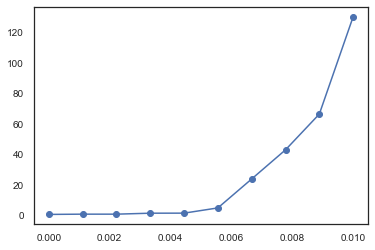

In [158]:
plt.plot(np.linspace(0,0.01,10),ST,'-o')

In [159]:
A=A_1+0
M_s1=[]

for w in np.linspace(0,1,20):
    ST_s1=[]
    for c in np.linspace(0,0.1,20):
        r0 = 12
        gamma = 1/14
        betae = r0*gamma
        betai = r0*gamma
        incubation = 9.5
        alpha = 0.13
        p = 1
        control_time = 300
        X0 = np.zeros(len(A))
        #seed spreader
        X0[60] = 2


        pnum = 50 ### 随机模拟次数
        res = parallel_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time,pnum)
        ST_s1.append(res)
    M_s1.append(ST_s1)
    print(ST_s1)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.54, 4.56, 87.96, 146.48, 162.48, 179.32, 184.28, 195.46, 194.66, 195.38, 197.5, 199.88, 203.62, 202.46, 205.18, 200.04, 205.42, 202.86, 204.5, 199.96]
[0.6, 5.24, 141.96, 224.64, 268.56, 260.14, 307.26, 319.12, 325.4, 333.42, 337.58, 329.6, 330.8, 331.78, 340.24, 339.42, 341.08, 340.66, 340.54, 347.5]
[0.66, 5.26, 141.38, 295.7, 366.88, 391.34, 410.86, 421.7, 435.04, 422.48, 436.26, 447.64, 458.04, 450.3, 461.42, 447.66, 461.56, 465.42, 456.42, 459.88]
[0.84, 4.64, 160.94, 383.2, 440.92, 478.92, 474.14, 479.26, 513.7, 545.24, 547.6, 521.1, 563.88, 550.62, 553.68, 563.74, 570.22, 571.32, 569.88, 571.44]
[0.72, 3.78, 143.2, 425.6, 461.26, 535.74, 584.62, 590.32, 647.78, 591.14, 618.92, 624.04, 633.04, 651.98, 636.4, 652.44, 668.24, 674.98, 658.48, 671.1]
[0.78, 4.86, 207.72, 399.32, 488.54, 569.92, 693.64, 635.78, 699.0, 719.1, 742.6, 745.14, 745.0, 715.22, 755.2, 766.14, 771.98, 769.7

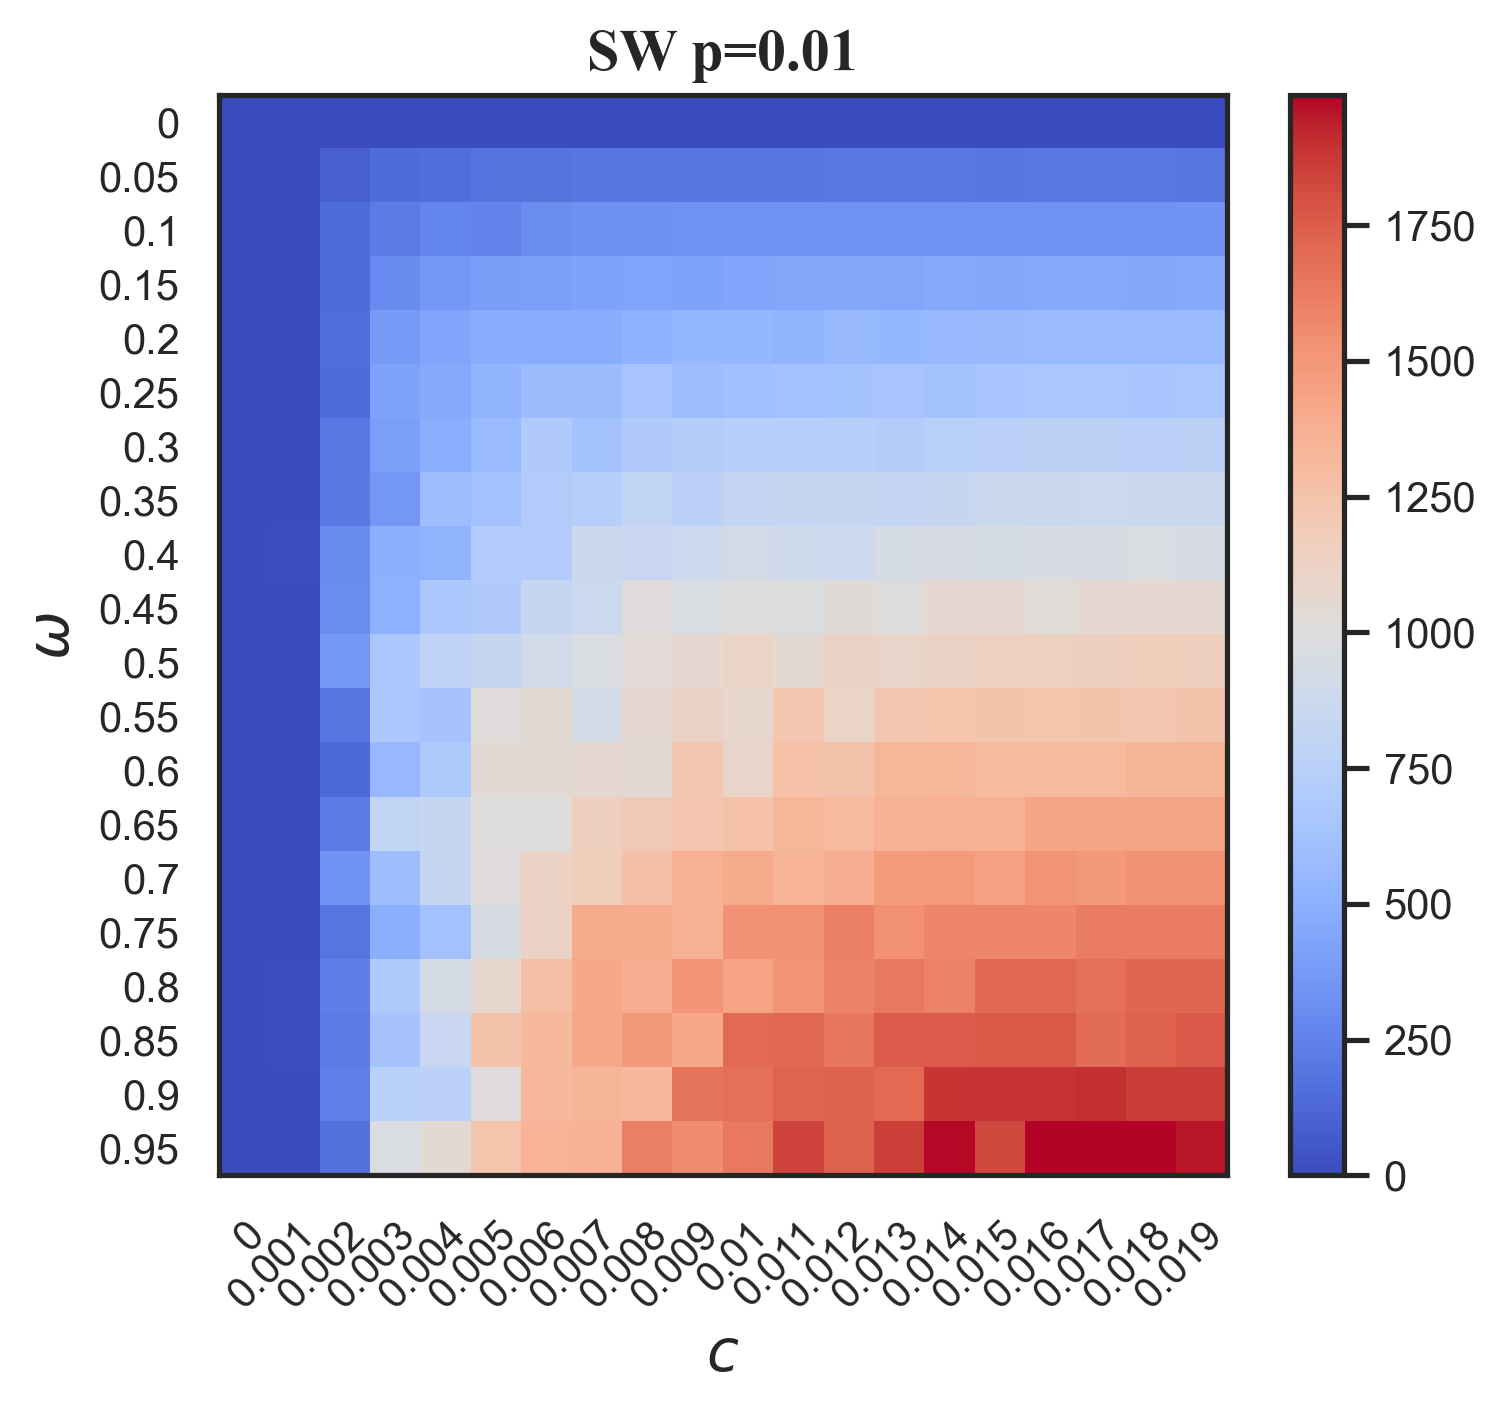

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
plt.subplots_adjust(top=0.94, bottom=0.22, left=0.15, right=0.99, hspace=0,
                    wspace=0)

tag_y = ["0", "0.05",  "0.1",  "0.15", "0.2", "0.25", "0.3", "0.35", "0.4", "0.45", "0.5", "0.55", "0.6", "0.65", "0.7", "0.75", "0.8", "0.85", "0.9", "0.95"]
tag_x = ["0", "0.001",  "0.002",  "0.003",  "0.004",  "0.005",  "0.006",  "0.007",  "0.008", "0.009",  "0.01", "0.011",  "0.012",  "0.013",  "0.014",  "0.015",  "0.016",  "0.017",  "0.018", "0.019"]


plt.imshow(M_s1, cmap='coolwarm', origin='upper', aspect="auto")
plt.colorbar()
ax.set_xticks(np.arange(len(tag_x)))
ax.set_yticks(np.arange(len(tag_y)))
ax.set_xticklabels(tag_x)
ax.set_yticklabels(tag_y)


plt.xticks(x,())

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.xlabel('$c$', default_font)
plt.ylabel('$\omega$', default_font)
ax.set_title("SW p=0.01", default_font)


plt.show()

#### 最短路径 3.44

In [91]:
@njit(nogil = True)
def parallel_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time,pnum):
    Steady = np.zeros(pnum)
    
    for ii in prange(pnum):
        S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
        Steady[ii] = Te[-1]
    res = np.mean(Steady)
    return res

In [92]:
@njit()
def update_model(X,A,incubation,betae,betai,alpha,gamma,p,w,c):
    ID = np.arange(len(A))
    nX = X.copy()
    for i in range(len(X)):
        neighbor_ID = ID[A[i]>0]#寻找邻居
        if X[i] == 0:#suspectible 
            #统计邻居节点状态进行感染
            #计算有多少
            nume=0
            numi=0
            for ni in neighbor_ID:
                if X[ni] == 1:
                    #S碰到E，统计人数
                    nume+=1
                elif X[ni] == 2:
                    #S碰到I
                    numi+=1
            #根据现有多少个A和I来计算传播概率*管控力度
            if np.random.random()< c*(1-(1-betai)**numi*(1-betae)**nume):
                nX[i] = 1
        if X[i] == 1:#ecubate
            #以潜伏天数的倒数*一定感染概率alpha转为确诊，或被移除
            if np.random.random()< 1/incubation:
                if np.random.random()< alpha:
                    nX[i] = 2#i
                else:
                    nX[i] = 4#r
                #检测力度被检测出来
                if np.random.random() < w * p:
                    nX[i] = 3#t
        if X[i] == 2:#infected to tested or recover 
            if np.random.random()< w * p:
                nX[i] = 3#t
            if np.random.random() < gamma:
                nX[i] = 4      
    return nX
                    
@njit()    
def loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time):
    T = 200
    Xp = X0.copy()
    S = np.zeros(T)
    E = np.zeros(T)
    I = np.zeros(T)
    Te = np.zeros(T)
    R = np.zeros(T)
    
    S[0] = np.sum(X0==0)
    E[0] = np.sum(X0==1)
    I[0] = np.sum(X0==2)
    Te[0] = np.sum(X0==3)
    R[0] = np.sum(X0==4)
    
    for t in range(T-1):  
        nX = update_model(Xp,A,incubation,betae,betai,alpha,gamma,p,w,c)
        Xp = nX.copy()
        S[t+1] = np.sum(nX==0)
        E[t+1] = np.sum(nX==1)
        I[t+1] = np.sum(nX==2)
        Te[t+1] = np.sum(nX==3)
        R[t+1] = np.sum(nX==4)
    return S,E,I,Te,R,nX 

In [93]:
def call(A):    
    r0 = 12
    gamma = 1/14
    betae = r0*gamma
    betai = r0*gamma*6/4
    incubation = 9.5
    alpha = 0.13

    #核酸检测窗口
    w = 1/7

    #检测力度
    p = 0.8

    #接触能力
    c = 0.03

    #静态管控时长
    control_time = 300

    X0 = np.zeros(len(A))
    #seed spreader
    X0[60] = 2

    interval = []
    fig = plt.figure(figsize=(12,8))
    plt.tick_params(labelsize = 25)
    #************多次模拟**************#
    for ii in range(30):
        S,E,I,Te,R,nX = loop_model(X0,A,incubation,betae,betai,alpha,gamma,p,w,c,control_time)
        plt.plot(Te)
        time = 0
        for jj in range(len(Te)):
                if Te[jj]>50:
                    time = jj-1
                if time != 0:
                    break
        if time != 0:
            interval.append(time)
    return interval

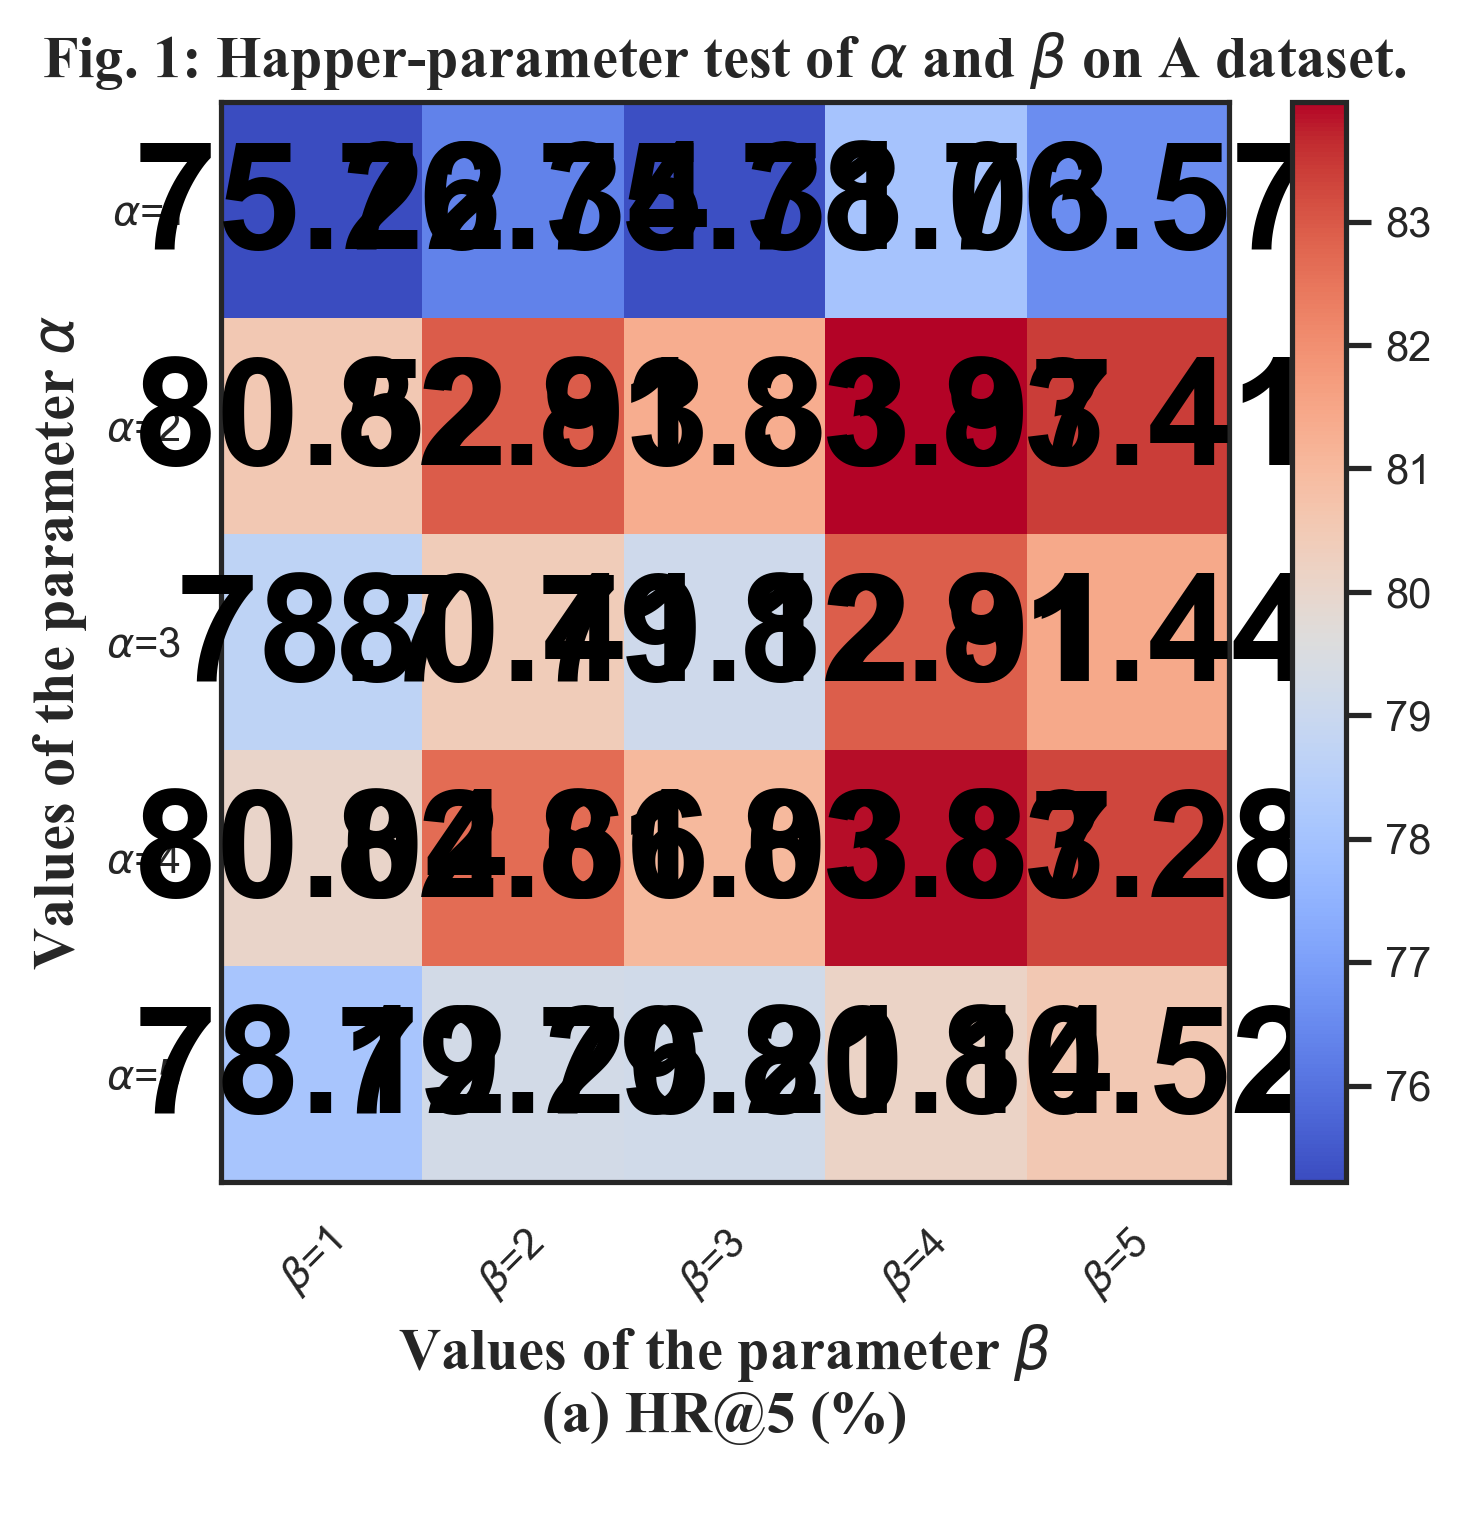

In [111]:
# @Author: Jinyu Zhang
# @Time: 2022/4/30 15:07
# @E-mail: JinyuZ1996@outlook.com
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

default_font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 14}
tag_y = ["$α$=1", "$α$=2", "$α$=3", "$α$=4", "$α$=5"]
tag_x = ["$β$=1", "$β$=2", "$β$=3", "$β$=4", "$β$=5"]

HR_5 = np.array([[75.22, 76.34, 75.31, 78.03, 76.57],
                 [80.52, 82.93, 81.33, 83.97, 83.41],
                 [78.70, 80.41, 79.12, 82.91, 81.44],
                 [80.04, 82.66, 81.03, 83.87, 83.28],
                 [78.12, 79.26, 79.21, 80.14, 80.52]])

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
plt.subplots_adjust(top=0.94, bottom=0.22, left=0.15, right=0.99, hspace=0,
                    wspace=0)
plt.rcParams['xtick.labelsize'] = 1
ax.set_xticks(np.arange(0, 5, 1))
ax.set_yticks(np.arange(len(tag_y)))
ax.set_xticklabels(tag_x)
ax.set_yticklabels(tag_y)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(tag_y)):
    for j in range(len(tag_x)):
        text = ax.text(j, i, HR_5[i, j],
                       ha="center", va="center", color="black", fontweight="bold")

plt.imshow(HR_5, cmap='coolwarm', origin='upper', aspect="auto")
plt.colorbar()
plt.xlabel('Values of the parameter $β$\n(a) HR@5 (%)\n', default_font)
plt.ylabel('Values of the parameter $α$', default_font)
ax.set_title("Fig. 1: Happer-parameter test of $α$ and $β$ on A dataset.", default_font)

plt.show()